# Predict Chicago Food Inspections 🍕

We will use data from the [Chicago Department of Public Health](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html) to build a model to predict whether a food establishment passed inspection or not.

The purpose of this model is to help inspectors use their time more efficiently by identifying establishments that will likely fail inspection.



In [1]:
# Install category_encoders and pdpbox
%%capture
import sys

if 'google.colab' in sys.modules:
    !pip install category_encoders
    !pip install pdpbox

In [22]:

#Analysis and wrangling
import pandas as pd
import numpy as np

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt

#Statisctics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, RocCurveDisplay
from sklearn.metrics import classification_report

#Encoders
import category_encoders as ce
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer

#Pipeline
from sklearn.pipeline import make_pipeline

#Bagged
from sklearn.ensemble import RandomForestClassifier

#Boosted
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

#Permution Importance
from sklearn.inspection import permutation_importance



#Extra
import xgboost as xgb



# Wrangle Data First 🤠


In [3]:
# Loading in data with URL
url = 'https://drive.google.com/uc?export=download&id=1aUnQ4AJK4UtW8JL9zPyYUMtkjIgQpqKT'
df = pd.read_csv(url, parse_dates=['Inspection Date'], index_col= 'Inspection Date')

# Display top 5 rows
df.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Type,Violations,Latitude,Longitude,Location,Fail,Serious Violations Found
Inspection Date,,,,,,,,,,,,,,,,,
2017-09-15,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1,2.0
2011-10-20,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0,0.0
2016-04-05,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0,0.0
2016-04-29,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0,0.0
2011-01-10,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0,0.0



# Data leakage detected

Dropping this column will stop our model from obtaining certian information that would harm our generated prediction results.

In [4]:

# Data leaking column
leaky_col = 'Serious Violations Found'

# Wrangle function
- Removes the "leaky" column.
- Removes high-cardinality categorical columns (more than `500` categories).
- Removes categorical columns that have only one category.
- Removes numerical columns that are unique identifiers for each observation, not features that would affect the target.

In [5]:
# wrangle function were I have included columns needing to be dropped.
def wrangle(df):

    df = df.drop(columns = ['Inspection ID','DBA Name','AKA Name','License #','Address','State','Violations', 'Serious Violations Found','Location'])
    return df

df = wrangle(df)

# Split Data
Split data for testing


In [6]:

target = 'Fail'

X = df.drop(columns = target)
y = df[target]

# Creating Train and Validation sets

In [7]:

cutoff = '2017'
mask = X.index < cutoff
X_train, y_train = X.loc[mask], y.loc[mask]
X_val, y_val = X.loc[~mask], y.loc[~mask]

# Establish Baseline


In [8]:

baseline_acc = y_train.value_counts(normalize = True).max()
print('Baseline accuracy:', baseline_acc)

Baseline accuracy: 0.7506634470557295


# Build Model
- RandomForest model
- GradientBoosting model


In [12]:
# Forest model
# n_estimators = 100, max_depth= 20
model_bag = make_pipeline(OrdinalEncoder(), SimpleImputer(), RandomForestClassifier())
model_bag.fit(X_train, y_train);

In [13]:
# Gradient model
model_boost = make_pipeline(OrdinalEncoder(), SimpleImputer(), GradientBoostingClassifier())
model_boost.fit(X_train, y_train);

# V. Check Metrics

Here are the accuracy scores for your two models. Did you beat the baseline? Which of your two models appears to perform better on your validation set?

In [21]:
print('Bagging Model')
print('Training accuracy:', model_bag.score(X_train, y_train))
print('Validation accuracy:', model_bag.score(X_val, y_val))
print()
print('Boosting Model')
print('Training accuracy:', model_boost.score(X_train, y_train))
print('Validation accuracy:', model_boost.score(X_val, y_val))
print()
print(f'Baseline: {baseline_acc}')

Bagging Model
Training accuracy: 0.9078346522581108
Validation accuracy: 0.6830211121022897

Boosting Model
Training accuracy: 0.7564252755397232
Validation accuracy: 0.703934978689662

Baseline: 0.7506634470557295


Plotting the ROC-curve for both models.

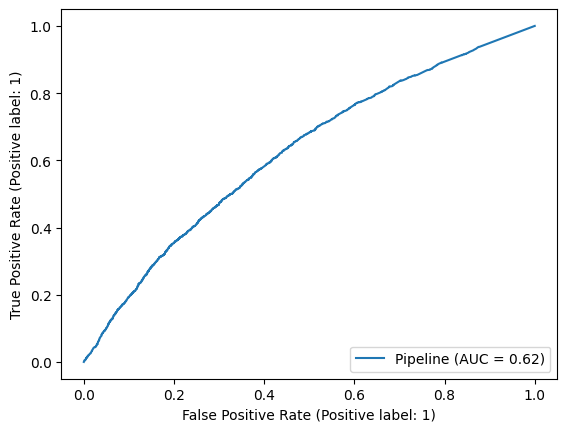

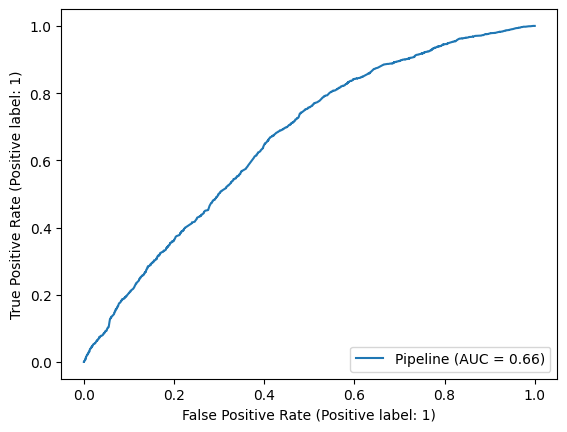

In [20]:

bag = RocCurveDisplay.from_estimator(model_bag, X_val, y_val)
boost = RocCurveDisplay.from_estimator(model_boost, X_val, y_val)

Creating a classification report for the model using the validation data.

In [23]:

model_cr = classification_report(y_val, model_boost.predict(X_val))
print(model_cr)

              precision    recall  f1-score   support

           0       0.71      0.99      0.82      7092
           1       0.53      0.03      0.05      2997

    accuracy                           0.70     10089
   macro avg       0.62      0.51      0.44     10089
weighted avg       0.66      0.70      0.59     10089



# Best model
 Creating a DataFrame with the model's permutation importances based on validation data.

- The index of the DataFrame will be feature names.
- The first column will be the mean importance.
- The second column should be the importance standard deviation.

In [25]:

model_to_permute = make_pipeline(OrdinalEncoder(), SimpleImputer(), XGBClassifier(n_estimators = 75, random_state = 42, n_jobs = -1))
model_to_permute.fit(X_train, y_train);
permutation_imp = permutation_importance(model_to_permute, X_val, y_val, random_state = 42)

In [26]:
data_perm = {'mean importance':permutation_imp['importances_mean'],
             'standard deviation':permutation_imp['importances_std']}
permutation_importances = pd.DataFrame(data_perm, index=X_val.columns).sort_values('mean importance')
permutation_importances

,mean importance,standard deviation
City,-0.000515,0.000192
Risk,-0.000416,0.000806
Zip,0.000020,0.001363
Longitude,0.001645,0.001418
Facility Type,0.001923,0.000802
Latitude,0.004341,0.001170
Inspection Type,0.008108,0.001732
